# Comparative Interrupted Time Series: a geo-experimentation example

This notebook demonstrates {term}`Comparative Interrupted Time Series<Comparative interrupted time-series>` (CITS) analysis using a geo-experimentation example. The analysis is based on the approach described in {cite:t}`orduz2022timebased`, which is partially based on {cite:t}`vaver2011measuring`.

## What is Comparative Interrupted Time Series?

**{term}`Comparative Interrupted Time Series<Comparative interrupted time-series>` (CITS)** extends the standard {term}`Interrupted Time Series<Interrupted time series design>` (ITS) design by incorporating control units as predictors in the model. This approach provides stronger causal inference by accounting for common trends and shocks that affect both treated and control units. Crucially, CITS helps guard against a key threat to ITS validity: confounding from unrelated changes that happen to occur at or near the time of intervention. Because control units are subject to the same external events but not the intervention itself, they help disentangle the treatment effect from coincidental changes.

In CausalPy, CITS is implemented using the `InterruptedTimeSeries` class with control units included as predictors in the model formula (e.g., `treated ~ 1 + control`). Unlike {term}`Synthetic Control`, CITS models can include an intercept and do not impose a sum-to-one constraint on control weights—this flexibility makes CITS a practical middle ground between standard ITS and Synthetic Control. When predictors in the model are not control units (e.g., just time or seasonality covariates), you have standard ITS; when you include one or more control units as predictors, you have CITS. Additional predictors such as temperature, time of year, or other covariates can also be included alongside control units.

CITS corresponds to the classic "multiple time-series" design described in the foundational quasi-experimental methods literature {cite:p}`campbell1963experimental`. This design strengthens causal inference when randomization is not possible by using comparison series to control for concurrent events and secular trends.

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pymc_extras.prior import Prior

import causalpy as cp

/Users/benjamv/miniforge3/envs/CausalPy/lib/python3.13/site-packages/arviz/__init__.py:50: FutureWarning: 
ArviZ is undergoing a major refactor to improve flexibility and extensibility while maintaining a user-friendly interface.
Some upcoming changes may be backward incompatible.
For details and migration guidance, visit: https://python.arviz.org/en/latest/user_guide/migration_guide.html
  warn(


In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
seed = 42

## The Geo-Experimentation Scenario

In this example, we analyze a marketing campaign experiment in which a company runs an advertising campaign in a subset of geographical regions (treated zipcodes) while other regions serve as controls. The outcome of interest is the order rate (orders per customer), and we want to estimate the causal impact of the campaign over its duration. This is a common scenario in digital marketing, retail, and platform businesses where randomization at the user level is not feasible, but geographical or regional-level experiments are possible.

### Load and Prepare Data

The dataset contains synthetic data for 100 zipcodes (33 treatment, 67 control) over 122 days (April 1 - July 31, 2022). A marketing campaign was run in the treatment zipcodes from July 1 to July 31, 2022.

In [3]:
# Load the zipcode data
df_raw = cp.load_data("zipcodes")

# Convert date column to datetime and set as index
df_raw["date"] = pd.to_datetime(df_raw["date"])

# Display basic information
print(f"Date range: {df_raw['date'].min()} to {df_raw['date'].max()}")
print(f"Total zipcodes: {df_raw['zipcode'].nunique()}")
print(
    f"Treatment zipcodes: {df_raw[df_raw['variant'] == 'treatment']['zipcode'].nunique()}"
)
print(
    f"Control zipcodes: {df_raw[df_raw['variant'] == 'control']['zipcode'].nunique()}"
)

df_raw.head()

Date range: 2022-04-01 00:00:00 to 2022-07-31 00:00:00
Total zipcodes: 100
Treatment zipcodes: 33
Control zipcodes: 67


,date,zipcode,is_campaign,is_weekend,is_weekday,norm_trend,population,strength,variant,is_campaign_treatment,order_rate_true_logit,order_rate_true_logit_no_treatment,order_rate_true,order_rate_true_no_treatment,orders,orders_no_treatment,order_rate,order_rate_no_treatment,expected_orders
0,2022-04-01,0,False,False,True,0.000000,3188,1,treatment,False,-1.750000,-1.750000,0.148047,0.148047,500,468,0.156838,0.146801,471.974467
1,2022-04-01,1,False,False,True,0.000082,10054,1,treatment,False,-1.749995,-1.749995,0.148048,0.148048,1521,1505,0.151283,0.149692,1488.472766
2,2022-04-01,2,False,False,True,0.000164,31881,1,treatment,False,-1.749990,-1.749990,0.148048,0.148048,4756,4703,0.149180,0.147517,4719.932276
3,2022-04-01,3,False,False,True,0.000246,2513,1,treatment,False,-1.749985,-1.749985,0.148049,0.148049,364,375,0.144847,0.149224,372.047286
4,2022-04-01,4,False,False,True,0.000328,7559,1,treatment,False,-1.749980,-1.749980,0.148050,0.148050,1121,1096,0.148300,0.144993,1119.107527


### Aggregate Data by Treatment Group

For CITS analysis, we aggregate the data across zipcodes within each group to produce one time series for the treated unit and one for the control unit. We scale by population to get comparable order rates per 1000 people.

In [4]:
# Aggregate by date and variant
df_agg = (
    df_raw.groupby(["date", "variant"])
    .agg({"orders": "sum", "population": "sum"})
    .reset_index()
)

# Calculate scaled order rate (orders per 1000 population)
df_agg["order_rate_scaled"] = (df_agg["orders"] / df_agg["population"]) * 1000

# Pivot to get treatment and control in separate columns
df_pivot = df_agg.pivot(index="date", columns="variant", values="order_rate_scaled")
df_pivot.columns.name = None
df_pivot = df_pivot.reset_index()

# Rename columns for clarity
df_pivot.columns = ["date", "control", "treatment"]

# Set date as index
df_pivot = df_pivot.set_index("date")

print("Aggregated data shape:", df_pivot.shape)
df_pivot.head()

Aggregated data shape: (122, 2)


,control,treatment
date,,
2022-04-01,129.569136,148.440776
2022-04-02,135.286461,154.535738
2022-04-03,135.646855,154.796926
2022-04-04,129.909237,148.492326
2022-04-05,130.229043,148.643540


### Visualise data

Before running the analysis, it's important to check that the treatment and control groups have similar pre-treatment trends. This parallel trends assumption is crucial for causal inference, and control series selection is critical for valid CITS inference—controls should be chosen to avoid contamination and differential shocks while helping address potential co-interventions {cite:p}`lopezbernal2018controls`.

We begin by examining the relationship between treatment and control units during the pre-treatment period. A strong correlation indicates the control series captures similar underlying drivers as the treatment series, which helps build an accurate counterfactual prediction. However, high correlation is **not** a test of the parallel trends assumption. Parallel trends requires that the *difference* between treatment and control remains stable over time—two series can be highly correlated yet diverge steadily. When examining the time series plot, look for whether the gap between the series is roughly constant in the pre-period; that's the visual check for parallel trends.

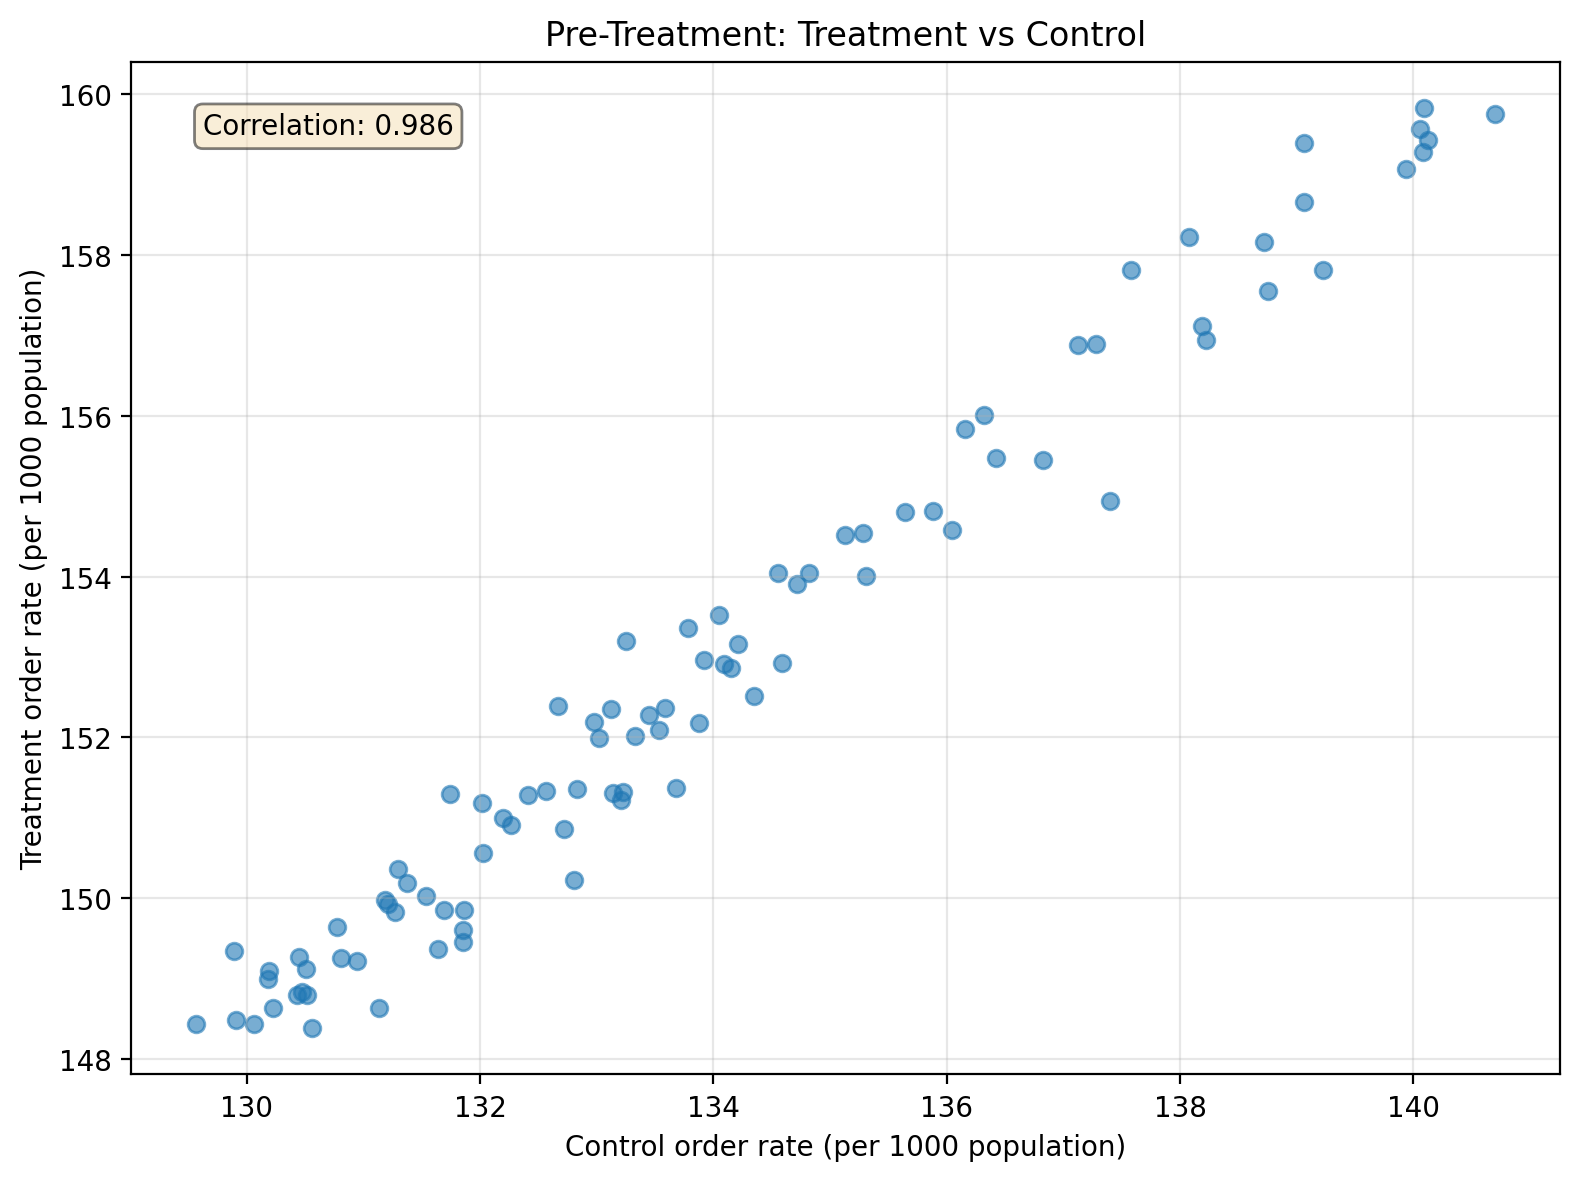

In [5]:
# Define the campaign period for filtering
campaign_start = pd.Timestamp("2022-07-01")

# Pre-treatment scatter plot
pre_treatment = df_pivot[df_pivot.index < campaign_start]

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(pre_treatment["control"], pre_treatment["treatment"], alpha=0.6)
ax.set_xlabel("Control order rate (per 1000 population)")
ax.set_ylabel("Treatment order rate (per 1000 population)")
ax.set_title("Pre-Treatment: Treatment vs Control")
ax.grid(True, alpha=0.3)

# Add correlation coefficient
corr = pre_treatment[["control", "treatment"]].corr().iloc[0, 1]
ax.text(
    0.05,
    0.95,
    f"Correlation: {corr:.3f}",
    transform=ax.transAxes,
    verticalalignment="top",
    bbox=dict(boxstyle="round", facecolor="wheat", alpha=0.5),
)
plt.tight_layout()
plt.show()

Second, let's plot the full timeseries for both the aggregated treatment and control. Eyeballing it, for the pre-treatment period we can see that the control series is similar to the treatment but with an offset. We can also see a clear increase in the treatment values when the campaign starts.

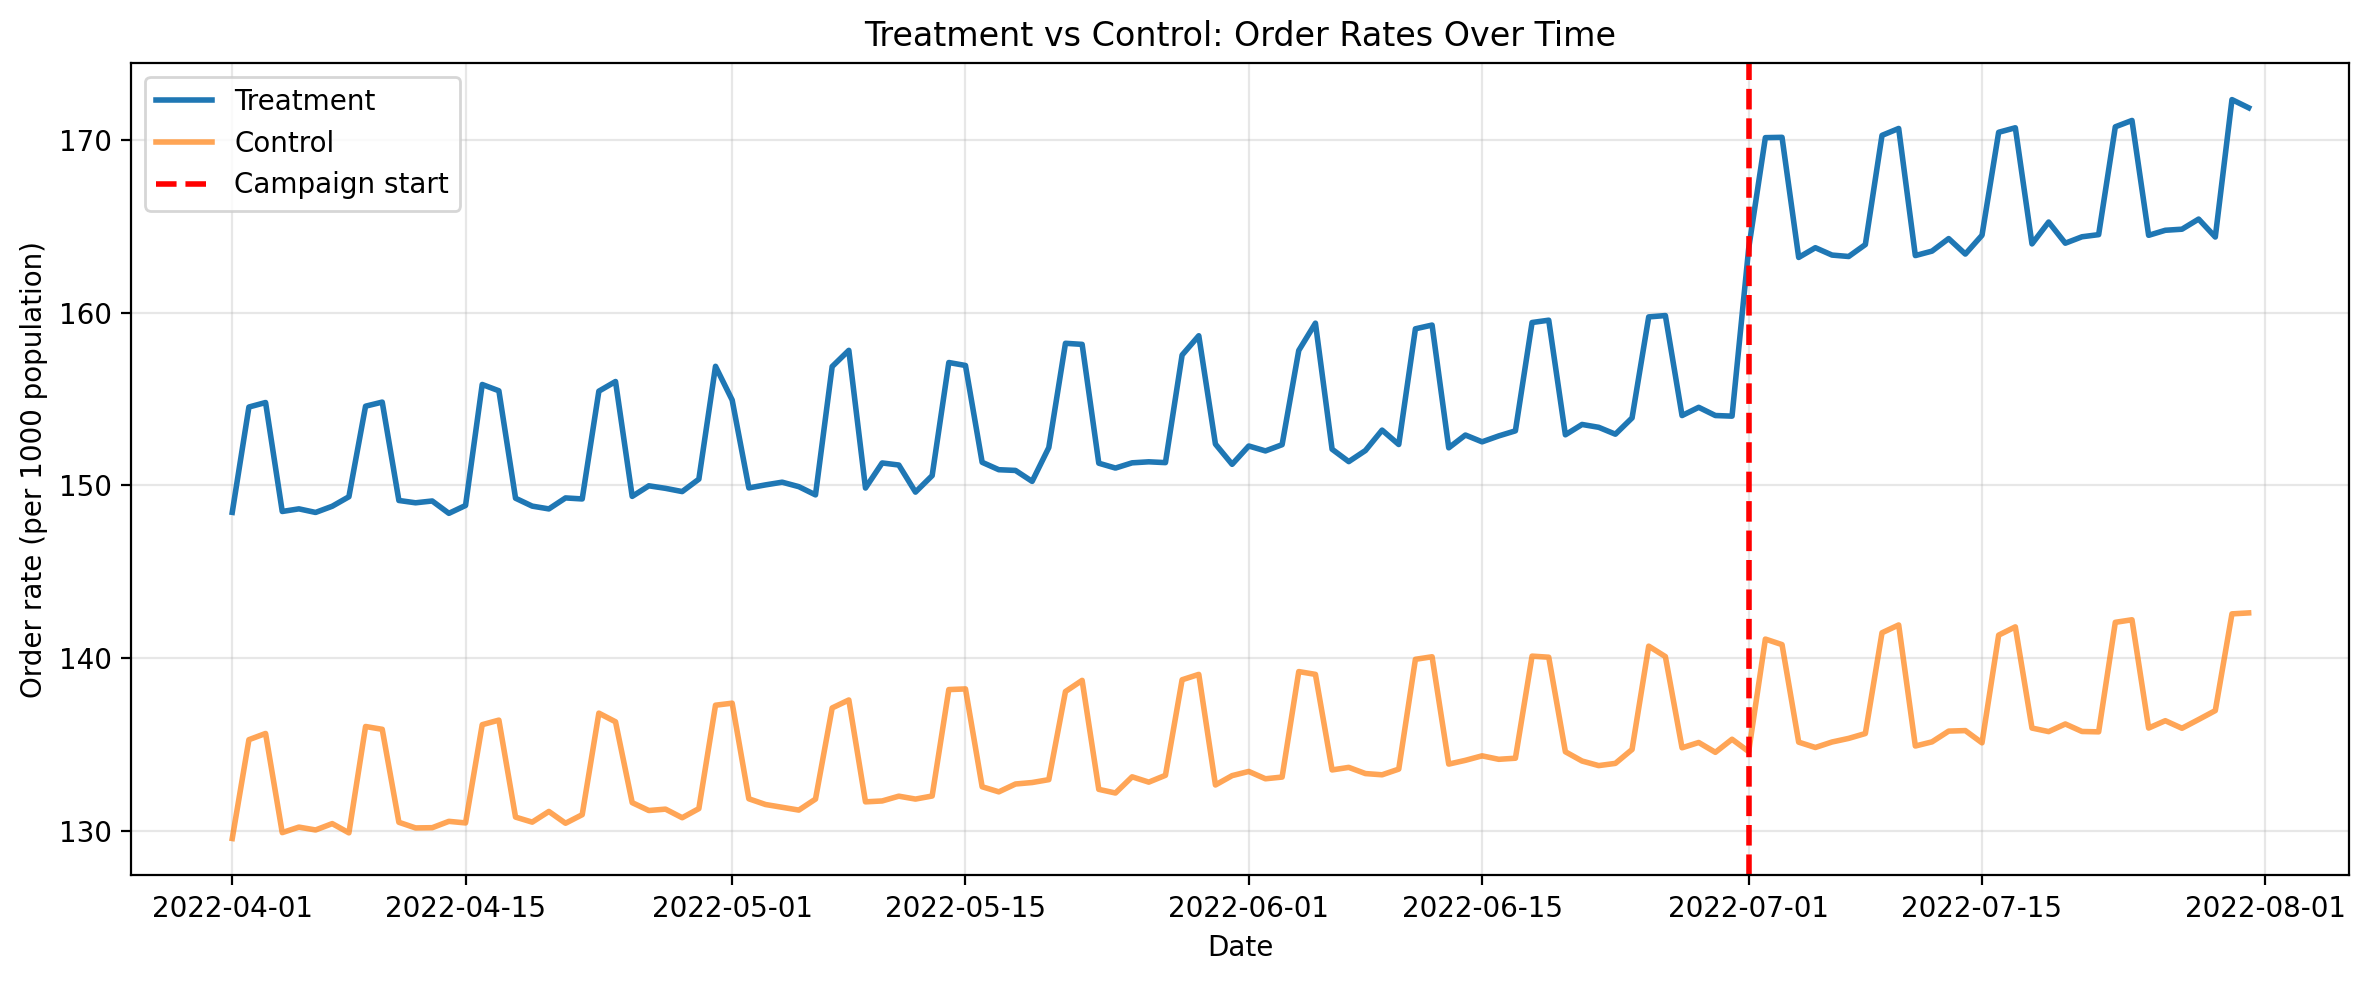

In [6]:
# Plot the time series (campaign_start already defined above)
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(df_pivot.index, df_pivot["treatment"], label="Treatment", linewidth=2)
ax.plot(df_pivot.index, df_pivot["control"], label="Control", linewidth=2, alpha=0.7)
ax.axvline(
    campaign_start, color="red", linestyle="--", linewidth=2, label="Campaign start"
)
ax.set_xlabel("Date")
ax.set_ylabel("Order rate (per 1000 population)")
ax.set_title("Treatment vs Control: Order Rates Over Time")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Finally, let's directly examine the parallel trends assumption by plotting the difference between treatment and control over the pre-treatment period. If parallel trends holds, this difference should be roughly constant—no systematic upward or downward trend.


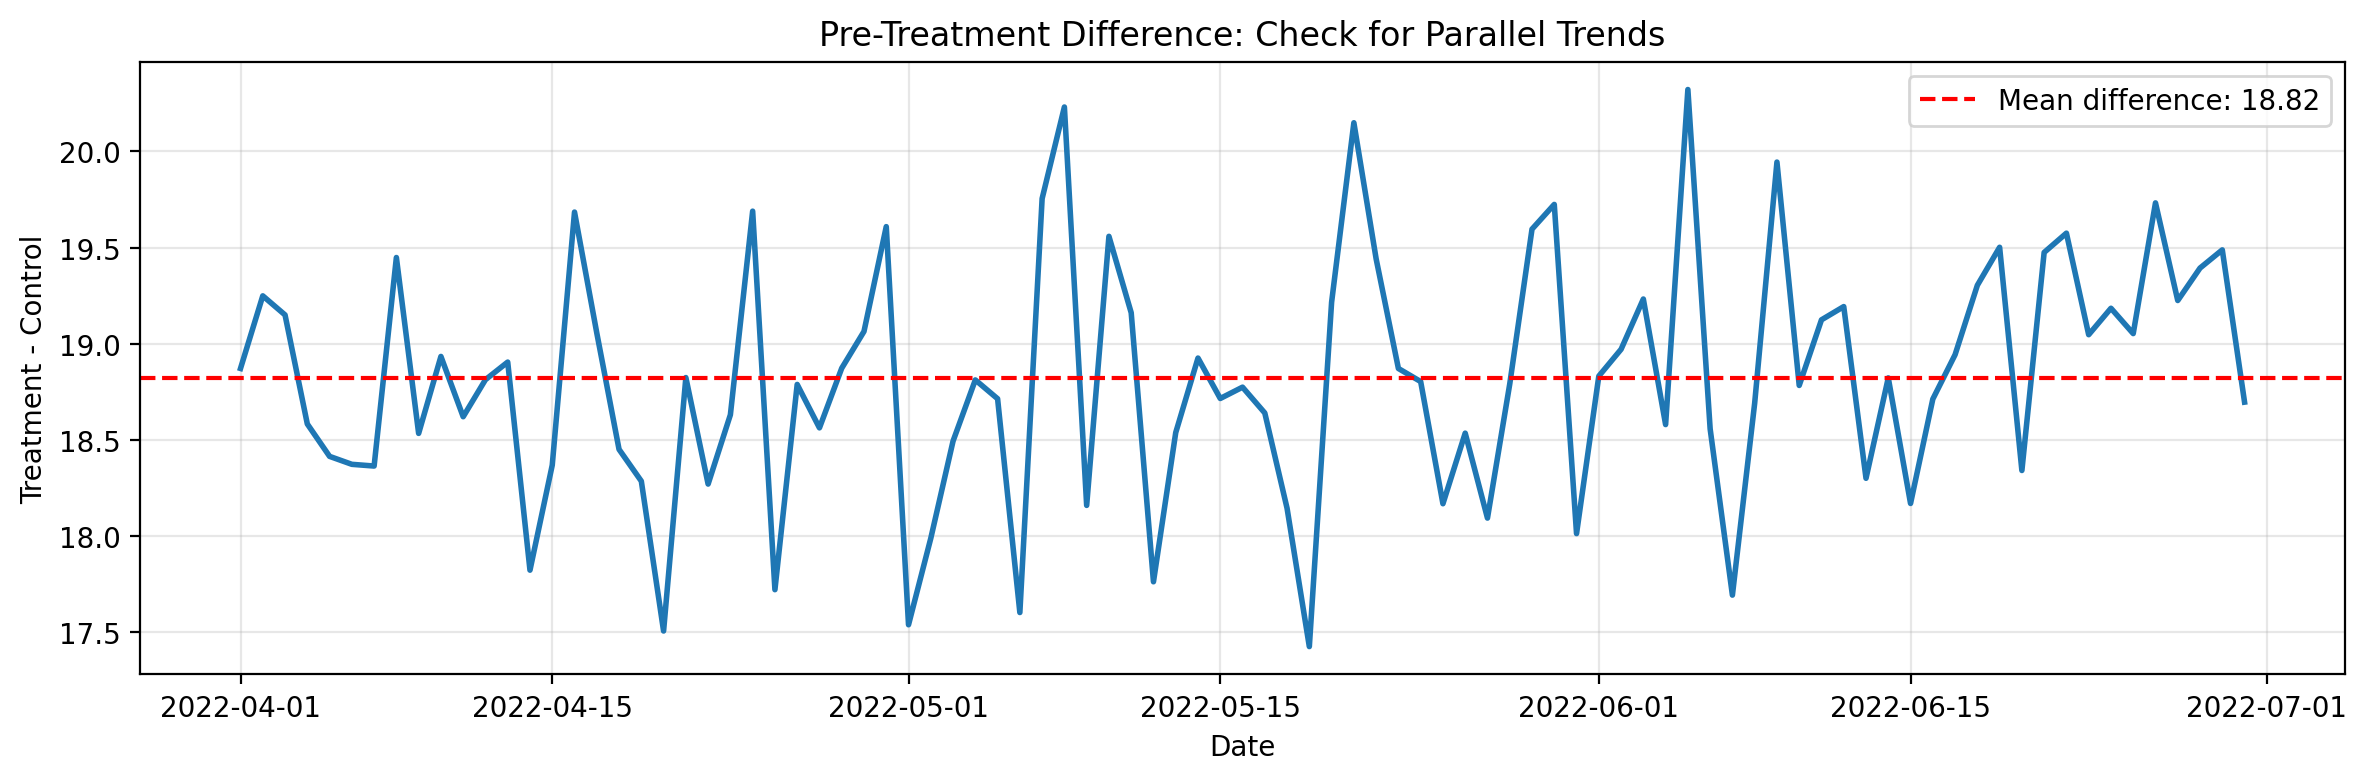

In [7]:
# Plot the difference over time to check parallel trends
fig, ax = plt.subplots(figsize=(12, 4))
diff = pre_treatment["treatment"] - pre_treatment["control"]
ax.plot(diff.index, diff.values, linewidth=2)
ax.axhline(
    diff.mean(),
    color="red",
    linestyle="--",
    label=f"Mean difference: {diff.mean():.2f}",
)
ax.set_xlabel("Date")
ax.set_ylabel("Treatment - Control")
ax.set_title("Pre-Treatment Difference: Check for Parallel Trends")
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## CITS Analysis with the InterruptedTimeSeries Class

Now we use CausalPy's `InterruptedTimeSeries` class to perform CITS analysis. The key difference from standard ITS is that we include the control unit as a predictor in our model formula:

```python
formula = "treatment ~ 1 + control"
```

This formula tells the model to predict `treatment` (the treated unit's order rate) using `control` (the control unit's order rate) as a predictor, plus an intercept. This formulation aligns with widely-used "multiple-group ITS" practice {cite:p}`linden2015conducting`; CausalPy implements the same design logic within a Bayesian framework.

The model will learn the relationship between treatment and control in the pre-intervention period, then use this to forecast a counterfactual for the post-intervention period.

To more closely follow the approach in {cite:t}`orduz2022timebased`, we override the default Normal likelihood with a Student-T distribution. The heavier tails of the Student-T make the model more robust to outliers, which is often desirable when working with real-world time series data that may contain occasional extreme values.

In [8]:
result = cp.InterruptedTimeSeries(
    df_pivot,
    treatment_time=campaign_start,
    formula="treatment ~ 1 + control",
    model=cp.pymc_models.LinearRegression(
        sample_kwargs={
            "random_seed": seed,
            "progressbar": False,
        },
        priors={
            "y_hat": Prior(
                "StudentT",
                nu=4,
                sigma=Prior("HalfNormal", sigma=1, dims=["treated_units"]),
                dims=["obs_ind", "treated_units"],
            ),
        },
    ),
)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, y_hat_sigma]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
Sampling: [beta, y_hat, y_hat_sigma]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]
Sampling: [y_hat]


In [9]:
result.summary()

==================================Pre-Post Fit==================================
Formula: treatment ~ 1 + control
Model coefficients:
    Intercept    6.7, 94% HDI [1.9, 11]
    control      1.1, 94% HDI [1.1, 1.1]
    y_hat_sigma  0.47, 94% HDI [0.39, 0.56]


### Interpret the Model Coefficients

The model coefficients tell us about the pre-intervention relationship between treatment and control. The **intercept** captures the baseline difference between treatment and control when the control value is zero, while the **control coefficient** tells us how much the treatment unit's order rate changes for each unit change in the control. A coefficient close to 1 indicates that treatment and control move in lockstep during the pre-period; values greater than 1 suggest the treatment is more sensitive to common factors, while values less than 1 suggest it is less sensitive.

## Visualize Results

The plot below shows three panels. The **top panel** displays the observed data (black dots) against the model's predictions: the pre-intervention fit appears in blue, and the counterfactual prediction (what would have happened without the campaign) appears in orange—the gap between observed values and the counterfactual represents the causal impact. The **middle panel** shows the causal impact at each time point, while the **bottom panel** tracks the cumulative impact over time.

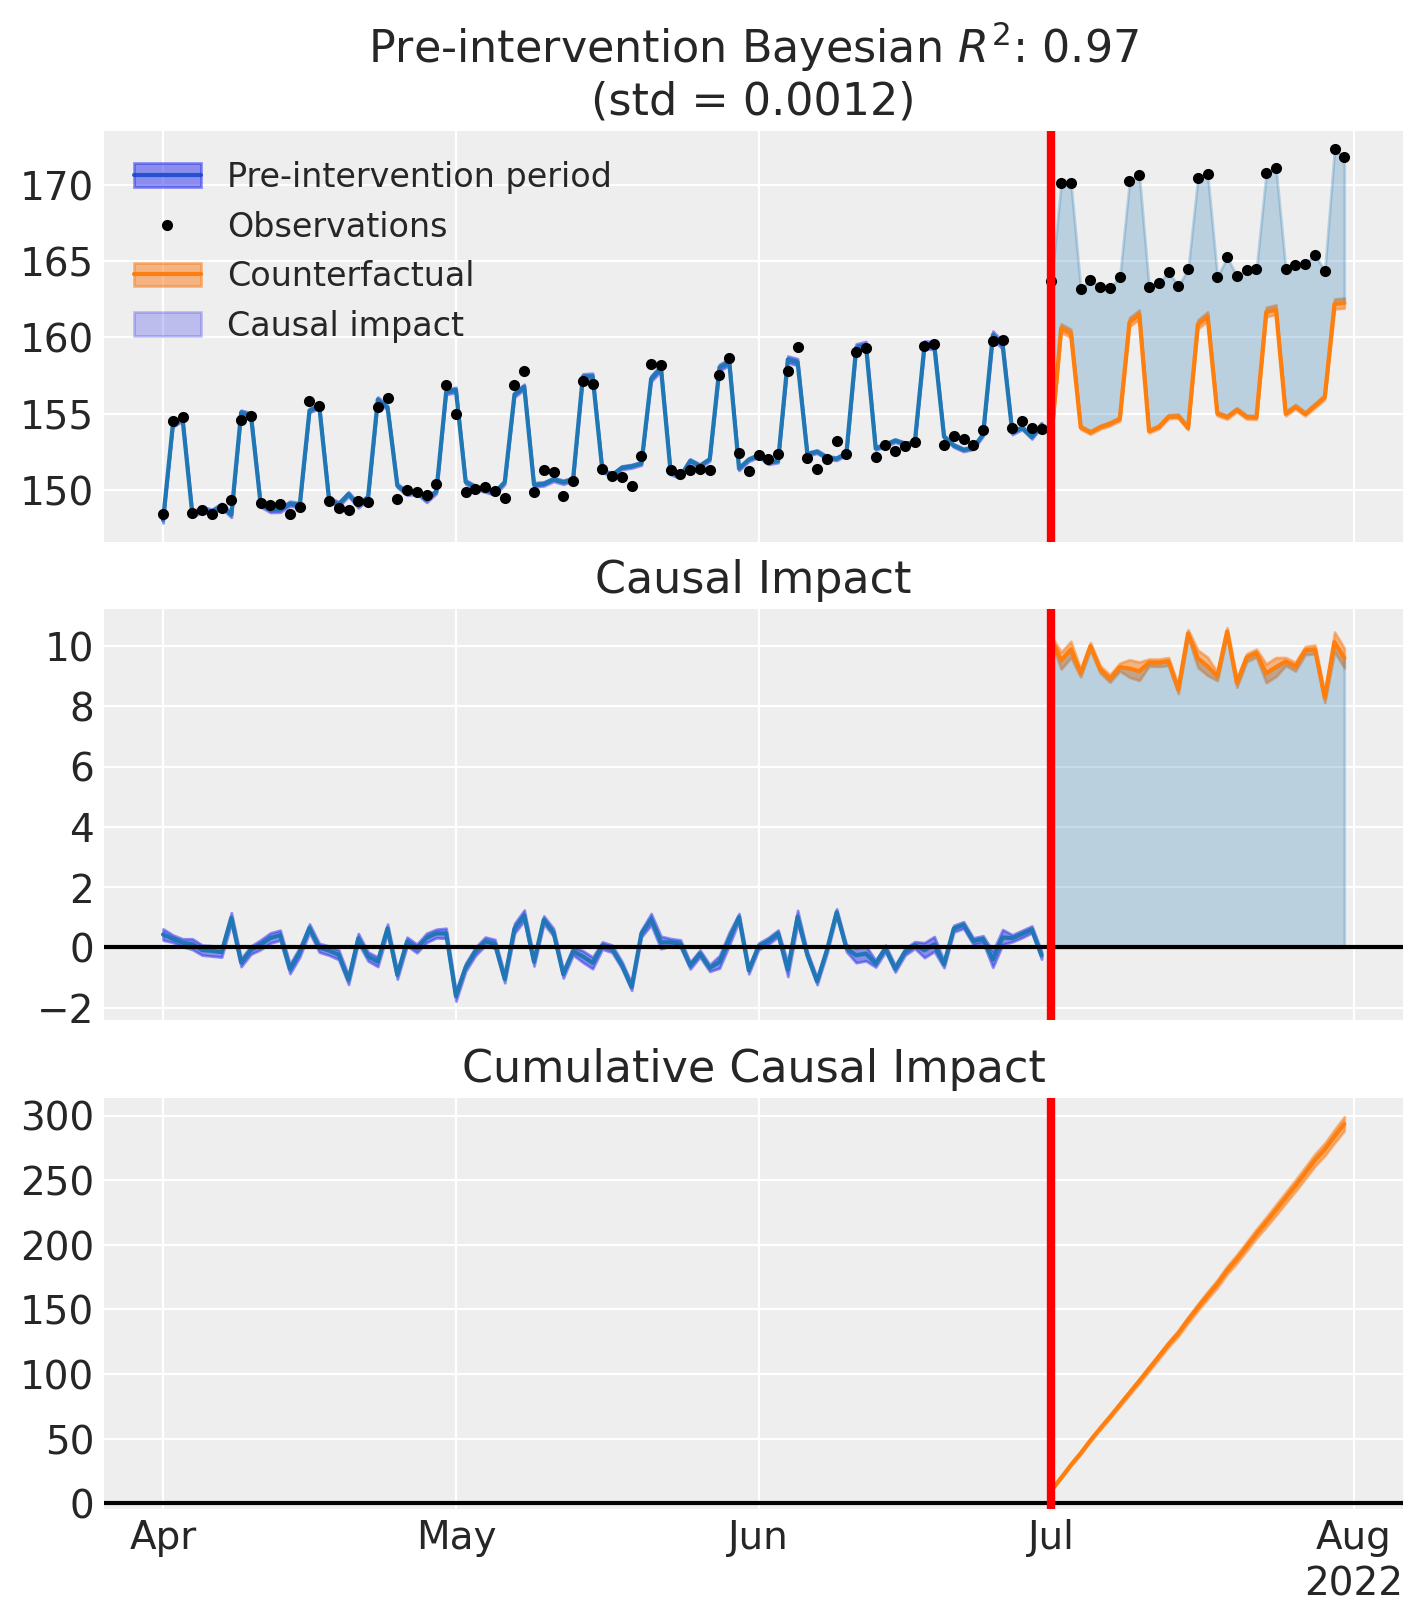

In [10]:
fig, ax = result.plot()

## Effect Summary

Let's quantify the causal effect of the campaign using the `effect_summary()` method. This method reports the **average impact** (the mean difference between observed and counterfactual order rates per day), the **cumulative impact** (total additional orders attributable to the campaign), **credible intervals** (Highest Density Intervals quantifying uncertainty), and **tail probabilities** (the probability that the effect is in the hypothesized direction). Together, these statistics provide evidence for decision-making about the campaign's effectiveness.

In [11]:
summary = result.effect_summary(direction="increase", alpha=0.05)
print(summary.text)
print("\nDetailed statistics:")
summary.table

Post-period (2022-07-01 00:00:00 to 2022-07-31 00:00:00), the average effect was 9.47 (95% HDI [9.27, 9.64]), with a posterior probability of an increase of 1.000. The cumulative effect was 293.50 (95% HDI [287.39, 298.88]); probability of an increase 1.000. Relative to the counterfactual, this equals 6.04% on average (95% HDI [5.90%, 6.16%]).

Detailed statistics:


,mean,median,hdi_lower,hdi_upper,p_gt_0,relative_mean,relative_hdi_lower,relative_hdi_upper
average,9.467877,9.468059,9.270774,9.641196,1.0,6.037995,5.904836,6.155291
cumulative,293.504174,293.509814,287.393980,298.877083,1.0,6.037995,5.904836,6.155291


## Model Diagnostics

It's important to check that our Bayesian model has converged properly and that the MCMC sampler has explored the posterior distribution effectively.

In [12]:
# Check model diagnostics
# Rhat should be close to 1.0, effective sample size should be large
az.summary(result.model.idata, var_names=["beta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"beta[unit_0, Intercept]",6.658,2.550,1.926,11.401,0.073,0.049,1231.0,1421.0,1.0
"beta[unit_0, control]",1.091,0.019,1.055,1.126,0.001,0.000,1232.0,1463.0,1.0


## Understanding the Method Family

Now that we have seen CITS in action, it is helpful to situate it within the broader family of interrupted time-series methods. The table below summarises how ITS, CITS, and Synthetic Control compare across key dimensions.

| Aspect | ITS | CITS | Synthetic Control |
|--------|-----|------|-------------------|
| **Control units** | None | Yes, as predictors | Yes, as predictors |
| **Intercept** | Typically yes | Yes | Typically no |
| **Weight constraint** | N/A | None | Sum to 1 |
| **Interpretation** | Counterfactual from time trends | Counterfactual from controls + trends | Weighted combination of controls |
| **Use case** | Single unit, strong trends | Multiple units, common trends | Multiple units, parallel trajectories |

### Why CITS is often preferred

The key advantage of CITS over standard ITS is its ability to control for concurrent events. Standard ITS is vulnerable whenever something else changes at the same time as the intervention—a new guideline, a coding change, or an economic shift can all confound the estimated effect. By including a control series that is exposed to the same external shocks but not the intervention, CITS helps account for those shared disturbances and improves internal validity. Adding comparison series is a recognized strengthening feature within the ITS family of designs {cite:p}`shadish_cook_cambell_2002`.

The identifying assumptions also differ. ITS assumes that, absent the intervention, the pre-intervention trend would have continued unchanged. CITS instead assumes that the treated and control series would have followed similar trajectories—often framed as a "parallel trends" assumption, though the model can accommodate rich pre-trends and seasonality.

### Data requirements and failure modes

These advantages come with additional requirements: CITS needs a credible control series, and the analyst must check for spillovers or contamination. CITS can be biased if the control is poorly chosen (different underlying drivers), if the intervention indirectly affects the control, or if other changes affect treated and control differently. Within-study comparisons have shown that CITS can achieve good validity, but may be biased when comparison unit construction or preprocessing is weak {cite:p}`stclair2016validity`.

### When to use which method

Use **ITS** when a good control series does not exist but you have many pre- and post-intervention observations and can argue that no major coincident changes occurred. Use **CITS** when you can identify a credible comparison series and want stronger protection against coincident events and secular trends. Use **Synthetic Control** when you have multiple control units and want to construct an optimal weighted combination, particularly when no single control tracks the treated unit well.

For a comprehensive treatment of ITS variants and quasi-experimental design more broadly, see {cite:t}`shadish_cook_cambell_2002`. For practical guidance on selecting and validating control series in public health applications, see {cite:t}`lopezbernal2018controls`.

### Summary

This notebook demonstrated how CITS provides robust causal inference by using control units to account for common trends and external shocks. The `InterruptedTimeSeries` class in CausalPy is flexible—it handles standard ITS, CITS, and various model specifications within a unified interface. Good pre-treatment fit is crucial for confidence in counterfactual predictions, and Bayesian credible intervals provide honest uncertainty quantification rather than just point estimates.

## References

:::{bibliography}
:filter: docname in docnames
:::